# Packages

In [10]:
using Plots
using XLSX
using YAML
using CSV
using DataFrames
using Statistics
using StatsBase
using Dates

# Import of GSE data

In [11]:
# Define the file path
general_path = @__DIR__
relative_path_GSE = "../data/GSE_prelievo.xlsx"
file_GSE= joinpath(general_path,relative_path_GSE)

# Read data from the first sheet of the Excel file
GSE_profiles= DataFrame(XLSX.readtable(file_GSE,"Foglio1"));

# Selection of relevant profiles

In [12]:
# Domestic, non domestic and public lighting are selected as representative of the different sectors
# Firstly, the data is filtered to select only the column of interest
selected_columns_residential = ["PDMM",#="PDMF"=#]
selected_columns_mono = ["PDMM","PICM","PAUM"]
selected_columns_bi = ["PDMF","PICF","PAUF"]

# The date is also selected
selected_date = ["Anno","Mese","Giorno","Ora"]

selected_complete = vcat(selected_date,selected_columns_residential)

# The data is then filtered to select only the rows of interest
GSE_profiles_resident = GSE_profiles[:,selected_complete]

# Show only first 20 rows
first(GSE_profiles_resident,15)

Row,Anno,Mese,Giorno,Ora,PDMM
,Any,Any,Any,Any,Any
1,2021,1,1,0,0.00104861
2,2021,1,1,1,0.000883816
3,2021,1,1,2,0.000794672
4,2021,1,1,3,0.00075429
5,2021,1,1,4,0.000749482
6,2021,1,1,5,0.000811035
7,2021,1,1,6,0.00100635
8,2021,1,1,7,0.00129499
9,2021,1,1,8,0.00138541


# Relative or absolute values

In [13]:
ARERA_all_power_consumption = [202, 168, 183, 154, 151, 174, 215, 179, 148, 142, 158, 176]
ARERA_1_3_power_consumption = [174, 144, 151, 133, 128, 143, 180, 158, 125, 122, 133, 152]
ARERA_average_month = [mean(ARERA_all_power_consumption) for i in 1:12]

# The data is then multiplied or not by ARERA values
# Select "Relative" or "Absolute" to choose the type of data
status = "Absolute"

# The GSE data is multiplied by the ARERA data to obtain the total consumption
# For each monthly firstly we do the sum over PDMM and then multiply by the ARERA data
GSE_monthly_sum = zeros(12)
if status == "Absolute"
    for i in 1:12
        GSE_monthly_sum[i] = sum(GSE_profiles_resident[GSE_profiles_resident[:,:Mese].==i,:PDMM])
        # The GSE data is then multiplied by the ARERA data when the month is the same
        GSE_profiles_resident[GSE_profiles_resident.Mese .== i,:PDMM] = GSE_profiles_resident[GSE_profiles_resident.Mese .== i,:PDMM] .* ARERA_average_month[i] ./ GSE_monthly_sum[i]
    end
end

# Plots

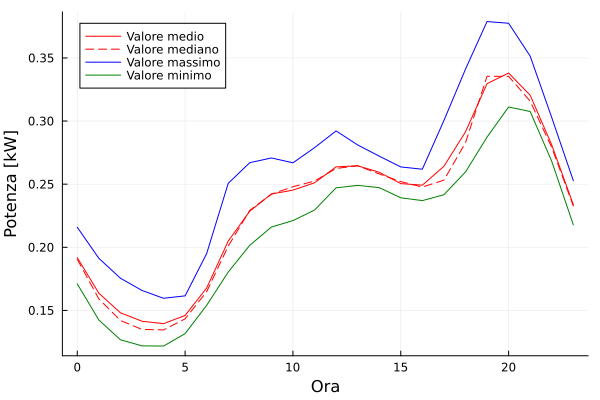

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\results\\Immagini\\GSE\\GSE_statistics.png"

In [14]:
# Assumendo che "Ora" sia una colonna in GSE_profiles e che tu voglia calcolare la media di una colonna chiamata "Valore"
grouped = groupby(GSE_profiles_resident, :Ora)
average_curve = combine(grouped, :PDMM => mean => :Valore_medio)
median_curve = combine(grouped, :PDMM => median => :Valore_mediano)
maximum_curve = combine(grouped, :PDMM => maximum => :Valore_massimo)
minimum_curve = combine(grouped, :PDMM => minimum => :Valore_minimo)

# Create base plot
if status == "Absolute"
    p0 = plot(xlab = "Ora", ylab = "Potenza [kW]",)
else
    p0 = plot(xlab = "Ora", ylab = "Distribuzione [%]",)
end

p1 = deepcopy(p0)


# Plot the data
plot!(p1, average_curve.Ora, average_curve.Valore_medio, label = "Valore medio", color = :red)
plot!(p1, median_curve.Ora, median_curve.Valore_mediano, label = "Valore mediano", color = :red, line = :dash)
plot!(p1, maximum_curve.Ora, maximum_curve.Valore_massimo, label = "Valore massimo", color = :blue)
plot!(p1, minimum_curve.Ora, minimum_curve.Valore_minimo, label = "Valore minimo", color = :green)

# Show the plot
display(p1)

# Save the plot
savefig(joinpath(general_path,"../results/Immagini/GSE/GSE_statistics.png"))

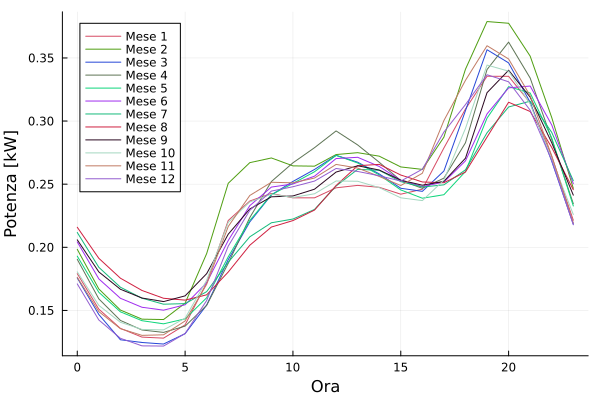

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\results\\Immagini\\GSE\\GSE_all_months.png"

In [47]:
# Raggruppa i dati per :Ora e :Mese e calcola la media
grouped_hourly = groupby(GSE_profiles_resident, [:Ora, :Mese])
average_curve_hourly = combine(grouped_hourly, :PDMM => mean => :Valore_medio)

# Crea un nuovo plot
p2 = deepcopy(p0)

# Plotta i dati
for i in unique(average_curve_hourly.Mese)
    subset = average_curve_hourly[average_curve_hourly.Mese .== i, :]
    plot!(p2, subset.Ora, subset.Valore_medio, label = "Mese $i", color = rand(RGB))
end

# Mostra il plot
display(p2)

# Salva il plot
savefig(joinpath(general_path,"../results/Immagini/GSE/GSE_all_months.png"))


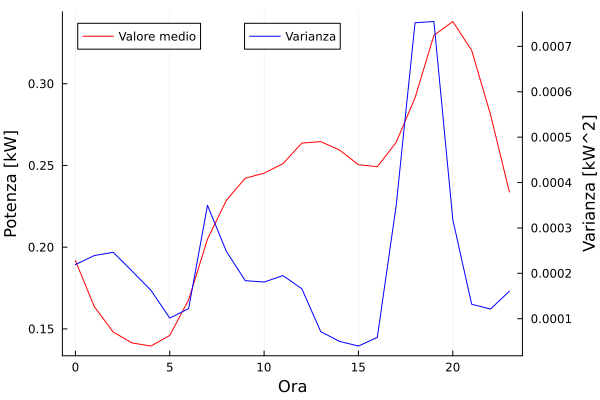

24×2 DataFrame
 Row │ Ora  Varianza    
     │ Any  Float64     
─────┼──────────────────
   1 │ 0    0.000219334
   2 │ 1    0.000239164
   3 │ 2    0.000246403
   4 │ 3    0.000204925
   5 │ 4    0.000162784
   6 │ 5    0.000101446
   7 │ 6    0.000122351
   8 │ 7    0.000349693
  ⋮  │  ⋮        ⋮
  18 │ 17   0.000349293
  19 │ 18   0.000751967
  20 │ 19   0.00075462
  21 │ 20   0.0003185
  22 │ 21   0.000131934
  23 │ 22   0.000121317
  24 │ 23   0.000160695
          9 rows omitted

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\results\\Immagini\\GSE\\GSE_var.png"

In [50]:
# Mostrare la varianza per ogni ora sull'asse secondario y
# Raggruppa i dati per :Ora e calcola la varianza e la covarianza
grouped_hourly = groupby(GSE_profiles_resident, [:Ora])
average_curve_hourly = combine(grouped_hourly, :PDMM => mean => :Valore_medio)
variance_curve_hourly = combine(grouped_hourly, :PDMM => var => :Varianza)


# Crea un nuovo plot e aggiungi l'asse secondario y
p2_1 = deepcopy(p0)

# Plotta i dati ma l'asse secondario y è utilizzato per la varianza e la covarianza a 10^-3
plot!(p2_1, average_curve_hourly.Ora, average_curve_hourly.Valore_medio, label = "Valore medio", color = :red)
p_secondary = twinx()
plot!(p_secondary, variance_curve_hourly.Ora, variance_curve_hourly.Varianza, label = "Varianza", color = :blue, legend = :top, ylabel = "Varianza [kW^2]")

# Mostra il plot
display(p2_1)

# Salva il plot
savefig(joinpath(general_path,"../results/Immagini/GSE/GSE_var.png"))

In [16]:
# Definisci una funzione per ottenere l'indice del valore massimo, minimo e medio
function get_indices(df)
    max_index = argmax(df.PDMM)
    min_index = argmin(df.PDMM)
    mean_value = mean(df.PDMM)
    _, median_index = findmin(abs.(df.PDMM .- median(df.PDMM)))
    _, mean_index = findmin(abs.(df.PDMM .- mean_value))
    return (max_index = df[max_index, :Mese], min_index = df[min_index, :Mese], mean_index = df[mean_index, :Mese], median_index = df[median_index, :Mese])
end

# Applica la funzione a ciascun gruppo
indices = combine(groupby(GSE_profiles_resident, :Ora), get_indices)

# Conta le ricorrenze dei valori in ciascuna colonna
max_counts = sort(countmap(indices.max_index), rev=false)
min_counts = sort(countmap(indices.min_index), rev=false)
mean_counts = sort(countmap(indices.mean_index), rev=false)
median_counts = sort(countmap(indices.median_index), rev=false)

# Stampa i risultati
println("Max counts: ", max_counts)
println("Min counts: ", min_counts)
println("Mean counts: ", mean_counts)
println("Median counts: ", median_counts)

Max counts: OrderedCollections.OrderedDict(2 => 11, 4 => 4, 7 => 1, 8 => 5, 9 => 1, 11 => 1, 12 => 1)
Min counts: OrderedCollections.OrderedDict(1 => 2, 3 => 3, 4 => 1, 5 => 1, 7 => 1, 8 => 8, 10 => 3, 12 => 5)
Mean counts: OrderedCollections.OrderedDict(1 => 1, 3 => 2, 4 => 1, 5 => 5, 6 => 1, 7 => 1, 9 => 3, 10 => 4, 11 => 2, 12 => 4)
Median counts: OrderedCollections.OrderedDict(1 => 2, 3 => 1, 4 => 4, 5 => 2, 7 => 4, 8 => 1, 9 => 1, 10 => 4, 12 => 5)


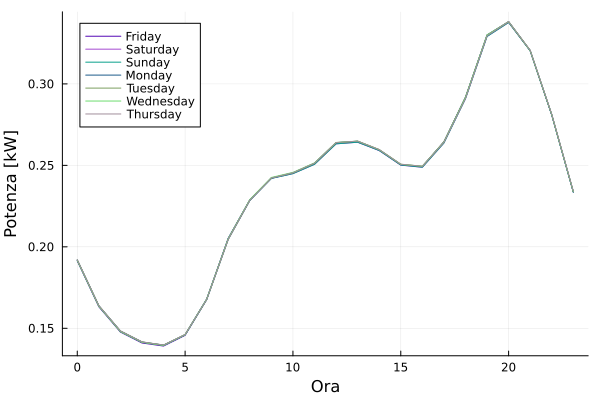

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\results\\Immagini\\GSE\\GSE_weekday.png"

In [17]:
#Aggiungo una nuova colonna che calcola il giorno della settimana utilizzando le colonne anno, mese e giorno
GSE_profiles_resident[!,:Giorno_settimana] = map(row -> Dates.dayname(Dates.Date(row[:Anno], row[:Mese], row[:Giorno])), eachrow(GSE_profiles_resident))

# Voglio ottenere la media della colonna PDMM per ciascun giorno della settimana
grouped_weekday = groupby(GSE_profiles_resident, [:Giorno_settimana,:Ora])
average_curve_weekday = combine(grouped_weekday, :PDMM => mean => :Valore_medio)

# Crea un nuovo plot
p3 = deepcopy(p0)

# Plotta i dati
for i in unique(average_curve_weekday.Giorno_settimana)
    subset = average_curve_weekday[average_curve_weekday.Giorno_settimana .== i, :]
    plot!(p3, subset.Ora, subset.Valore_medio, label = i, color = rand(RGB))
end

# Mostra il plot
display(p3)

# Salva il plot
savefig(joinpath(general_path,"../results/Immagini/GSE/GSE_weekday.png"))

# Export results

In [18]:
# Save the data as a csv file for further analysis
CSV.write(joinpath(general_path,"../results/Dati/GSE_profiles_resident_v0_all_power_average.csv"), GSE_profiles_resident)

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\src\\../results/Dati/GSE_profiles_resident_v0_all_power_average.csv"